# Идентификация частотного скана сигнала релаксации, состоящего из пяти экспоненциальных составляющих, моноэкспоненциальной моделью

## Импорт необходимых модулей

In [1]:
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

%matplotlib inline

from fsmodels import FrequencyScan, MultiExpFrequencyScan

## Ввод параметров моделирования

In [2]:
N_EXPS = 3

N_SCANS = 31

CENTRAL_TIME_CONSTANT_POWER = -2

DEV = 1.0

F_PULSE = 20 * 10 ** -6


FREQUENCY_POWERS = np.linspace(0, 3.5, 100)

## Расчёт массива параметров моделей частотных сканов

In [3]:
def get_exps_params(n_exps,
                    n_scans,
                    central_time_constant_power,
                    dev,
                    amps = None
                   ):
    
    dev = np.linspace(-dev, dev, n_exps) * np.linspace(0, 1, n_scans).reshape(-1,1)
    time_constant_powers = central_time_constant_power + dev
    
    if amps is None:
        amplitudes = np.ones_like(time_constant_powers)
    else:
        amplitudes = np.array(amps)
        
    exps_params = np.stack([time_constant_powers, amplitudes], axis=-1)
    
    return exps_params

In [4]:
exps_params = get_exps_params(n_exps = N_EXPS,
                n_scans = N_SCANS,
                central_time_constant_power = CENTRAL_TIME_CONSTANT_POWER,
                dev = DEV,
                amps = None
               )

## Расчёт массива тестовых данных (сканов, на которых будет выполняться идентификация модели)

In [5]:
def test_data_prep(exps_params,
                   f_pulse,
                   frequency_powers,
                   n_jobs = 1
                  ):
    
    def get_dlts(params):
        model = MultiExpFrequencyScan(n_exps = params.shape[0], 
                                      filling_pulse = f_pulse,
                                      exps_params = params)
        return model(frequency_powers).numpy()
    
    return Parallel(n_jobs=n_jobs)(delayed(get_dlts)(params) for params in exps_params)

In [6]:
test_data = test_data_prep(frequency_powers =FREQUENCY_POWERS,
                           exps_params = exps_params,
                           f_pulse = F_PULSE,
                           n_jobs = -1,
                          )

## Идентификация параметров моделей на массиве тестовых данных

In [7]:
def identification(frequency_powers,
                   dlts,
                   f_pulse,
                   learning_rate = 0.05,
                  ):
    
    max_abs_index = np.absolute(dlts).argmax()
    initial_time_constant = -frequency_powers[max_abs_index]
    initial_amplitude = dlts[max_abs_index]
    
    
    model = FrequencyScan(amplitude = initial_amplitude,
                          time_constant_power = initial_time_constant,
                          filling_pulse = f_pulse,
                          fit_p_coef = True,
                          learning_rate = learning_rate,
                          n_iters = 1000,
                          stop_val = 10**-10,
                          verbose = False,
                          tf_in_out = False
                         )
    
    fit_results = model.fit(frequency_powers, dlts)
    
    return fit_results.iloc[[0], :], fit_results.iloc[[-1], :], fit_results.loss.to_numpy()


def batch_identification(test_data,
                         frequency_powers,
                         f_pulse,
                         learning_rate=0.05,
                         n_jobs = 1
                        ):
    res = Parallel(n_jobs=n_jobs)(delayed(identification)(frequency_powers, dlts, 
                                                          f_pulse, learning_rate) for dlts in test_data)

    loss_path = list(zip(*res))[-1]
    res = [frame[:-1] for frame in res]
    
    res = [pd.concat(frame, ignore_index=True) for frame in zip(*res)]
    
    return {'initial_params': res[0], 'final_params': res[1], 'loss_path': loss_path}

In [8]:
identification_results = batch_identification(test_data = test_data,
                                              frequency_powers = FREQUENCY_POWERS, 
                                              f_pulse = F_PULSE,
                                              n_jobs = -1)

In [9]:
def results_to_csv(results, exps_params, filling_pulse, path):
    columns_names = [f'tc_pow_{i}' for i in range(exps_params.shape[1])]
    columns_names += [f'amp_{i}' for i in range(exps_params.shape[1])]
    
    e_params = exps_params.transpose(0,2,1).reshape(-1, exps_params.shape[1]*exps_params.shape[2])
    
    res = results.copy()
    res[columns_names] = e_params
    
    res['filling_pulse'] = filling_pulse
    res['n_exps'] = exps_params.shape[1]
    
    res.to_csv(path, index=False)
    return res

## Сохранение результатов идентификации

In [10]:
results_to_csv(results=identification_results['final_params'],
               exps_params=exps_params,
               filling_pulse=F_PULSE,
               path='../models/3-exp-clear/models_parameters.csv')

,amplitude,time_constant_power,p_coef,loss,tc_pow_0,tc_pow_1,tc_pow_2,amp_0,amp_1,amp_2,filling_pulse,n_exps
0,2.999859,-2.0,0.999919,0.0,-2.000000,-2.0,-2.000000,1.0,1.0,1.0,0.00002,3
1,2.995593,-2.000003,0.997251,0.0,-2.033333,-2.0,-1.966667,1.0,1.0,1.0,0.00002,3
2,2.982877,-2.000008,0.989316,0.000007,-2.066667,-2.0,-1.933333,1.0,1.0,1.0,0.00002,3
3,2.96196,-1.999999,0.976326,0.000037,-2.100000,-2.0,-1.900000,1.0,1.0,1.0,0.00002,3
4,2.933237,-1.999953,0.958611,0.000114,-2.133333,-2.0,-1.866667,1.0,1.0,1.0,0.00002,3
5,2.897503,-1.999837,0.936755,0.000269,-2.166667,-2.0,-1.833333,1.0,1.0,1.0,0.00002,3
6,2.854841,-1.999611,0.910967,0.000535,-2.200000,-2.0,-1.800000,1.0,1.0,1.0,0.00002,3
7,2.806237,-1.999227,0.881961,0.000943,-2.233333,-2.0,-1.766667,1.0,1.0,1.0,0.00002,3
8,2.752448,-1.998633,0.850314,0.001521,-2.266667,-2.0,-1.733333,1.0,1.0,1.0,0.00002,3
9,2.694257,-1.997773,0.816602,0.002287,-2.300000,-2.0,-1.700000,1.0,1.0,1.0,0.00002,3


## Вывод графиков на экран

In [11]:
def plot_spectr(exps_params):
    fig, ax = plt.subplots(1,1)
    
    for TC, AMP in exps_params:
        ax.semilogx([10 ** TC, 10 ** TC], [0, AMP], '-b')
        
    ax.set_title('Спектр')
    ax.set_xlabel('Постоянная времени, с')
    ax.set_ylabel('Амплитуда')
    ax.grid()
    ax.set_xlim([1, 1/2500])
    ax.set_ylim([0, 1.4])
    
    return fig, ax

In [12]:
def plot_model(frequency_powers, experimental_values, initial_params, final_params, f_pulse):
    model = FrequencyScan(amplitude = initial_params['amplitude'],
                          time_constant_power = initial_params['time_constant_power'],
                          filling_pulse = f_pulse,
                          p_coef = initial_params['p_coef'],
                         )
    initial_dlts = model(frequency_powers)
    
    model = FrequencyScan(amplitude = final_params['amplitude'],
                          time_constant_power = final_params['time_constant_power'],
                          filling_pulse = f_pulse,
                          p_coef = final_params['p_coef'],
                         )
    final_dlts = model(frequency_powers)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    ax.plot(frequency_powers, experimental_values, 'xg', label='Экспериментальные\nданные', )
    ax.plot(frequency_powers, initial_dlts, '--b', label='Начальная\nмодель')
    ax.plot(frequency_powers, final_dlts, '-r', label='Идентифицированная\nмодель')
    ax.grid()
    ax.set_xlim([0, 3.5])
    ax.legend()
    ax.set_ylabel('DLTS, условные еденицы')
    ax.set_xlabel('log10(Частота), log10(Гц)')
    plt.title('Результат идентификации модели')
    
    return fig, ax

In [13]:
def plot_loss_path(loss_path):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    path = loss_path / loss_path.max()
    
    ax.plot(path)
    
    ax.grid()
    ax.set_ylim([0,1])
    ax.set_xlim([0, path.shape[0]])
    ax.set_ylabel('Нормализованная среднеквадратическая ошибка')
    ax.set_xlabel('Номер итерации')
    ax.set_title('Значения среднеквадратической \nошибки в процессе идентификации')
    
    return fig, ax

In [14]:
def batch_plot(frequency_powers, 
               experimental_values, 
               exps_params,
               identification_results,
               f_pulse,
               save_to=None
              ):
    
    for i in range(exps_params.shape[0]):
        print(f'Спектр № {i}')
        print(f'exps_params:\n{exps_params[i]}')
        print(f"Результаты идентификации:\n{identification_results['final_params'].iloc[[i], :]}")
        
        plot_spectr(exps_params[i])
        
        if save_to is not None:
            plt.savefig(save_to + 'spectr' + f'{i}' + '.pdf', bbox_inches='tight')
        
        plt.show()
        
        
        plot_model(frequency_powers = frequency_powers, 
                   experimental_values = experimental_values[i], 
                   initial_params = identification_results['initial_params'].iloc[[i], :], 
                   final_params = identification_results['final_params'].iloc[[i], :], 
                   f_pulse = f_pulse)
        
        if save_to is not None:
            plt.savefig(save_to + 'identification_results_' + f'{i}' + '.pdf', bbox_inches='tight')
            
        plot_loss_path(identification_results['loss_path'][i])
        if save_to is not None:
            plt.savefig(save_to + 'loss_path_' + f'{i}' + '.pdf', bbox_inches='tight')
            
        plt.show()

Спектр № 0
exps_params:
[[-2.  1.]
 [-2.  1.]
 [-2.  1.]]
Результаты идентификации:
  amplitude time_constant_power    p_coef loss
0  2.999859                -2.0  0.999919  0.0


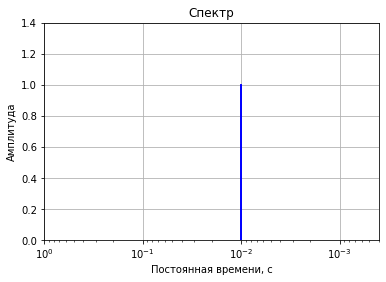

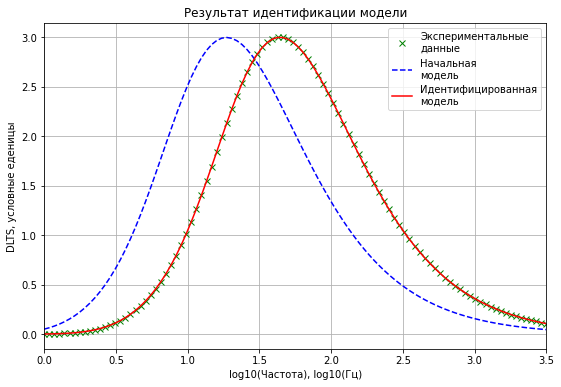

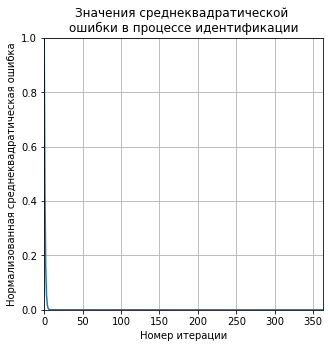

Спектр № 1
exps_params:
[[-2.03333333  1.        ]
 [-2.          1.        ]
 [-1.96666667  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef loss
1  2.995593           -2.000003  0.997251  0.0


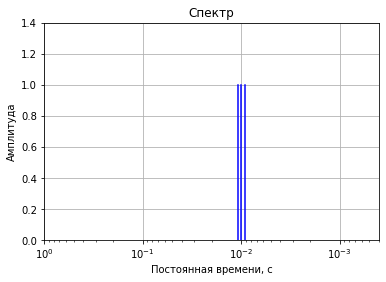

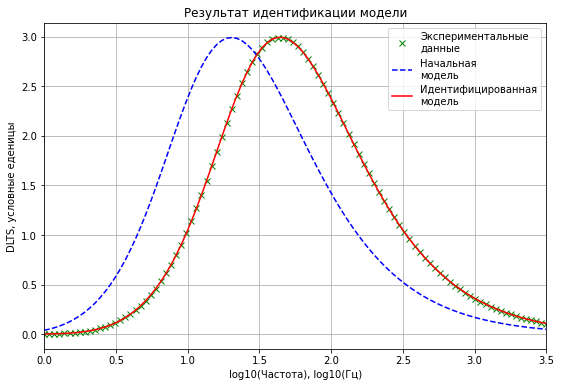

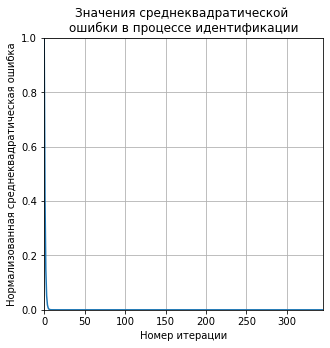

Спектр № 2
exps_params:
[[-2.06666667  1.        ]
 [-2.          1.        ]
 [-1.93333333  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
2  2.982877           -2.000008  0.989316  0.000007


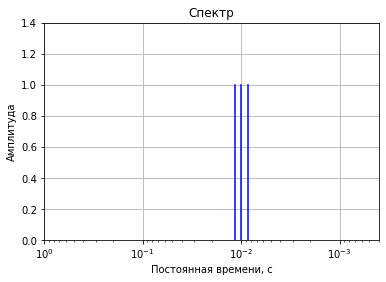

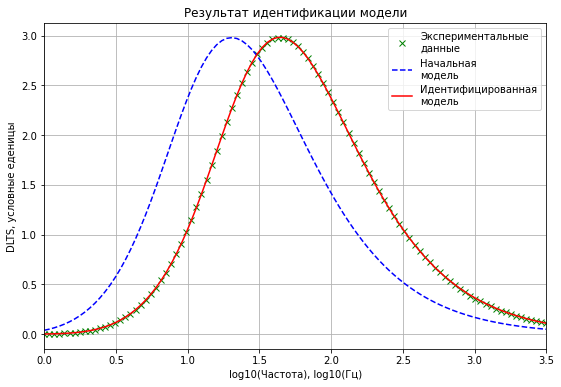

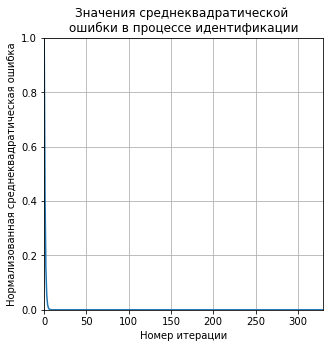

Спектр № 3
exps_params:
[[-2.1  1. ]
 [-2.   1. ]
 [-1.9  1. ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
3   2.96196           -1.999999  0.976326  0.000037


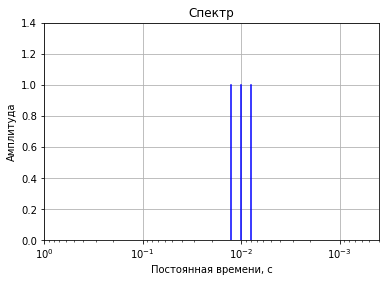

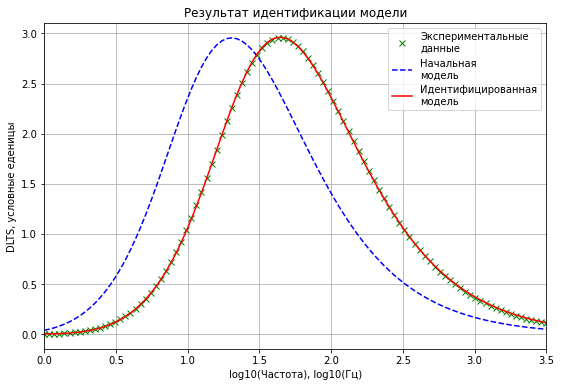

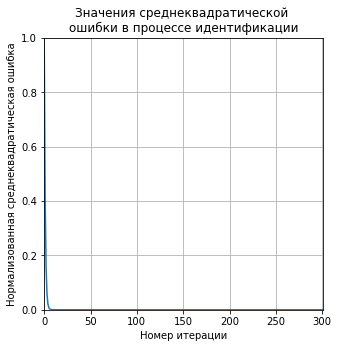

Спектр № 4
exps_params:
[[-2.13333333  1.        ]
 [-2.          1.        ]
 [-1.86666667  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
4  2.933237           -1.999953  0.958611  0.000114


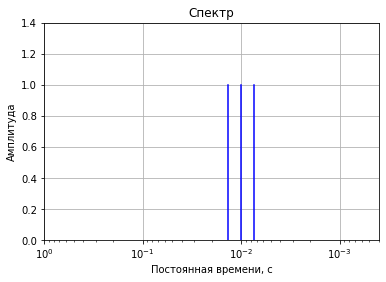

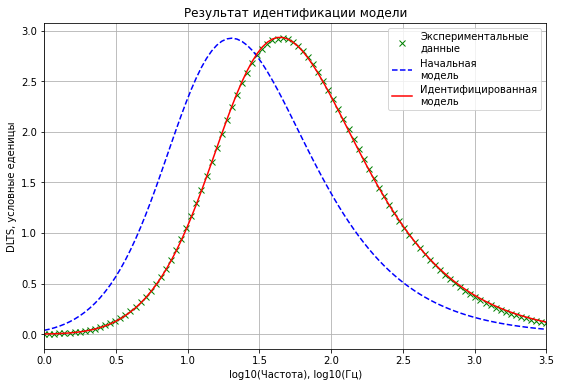

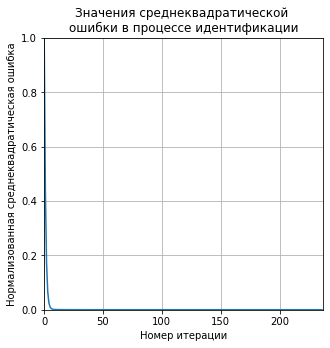

Спектр № 5
exps_params:
[[-2.16666667  1.        ]
 [-2.          1.        ]
 [-1.83333333  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
5  2.897503           -1.999837  0.936755  0.000269


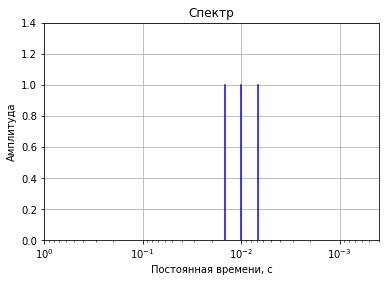

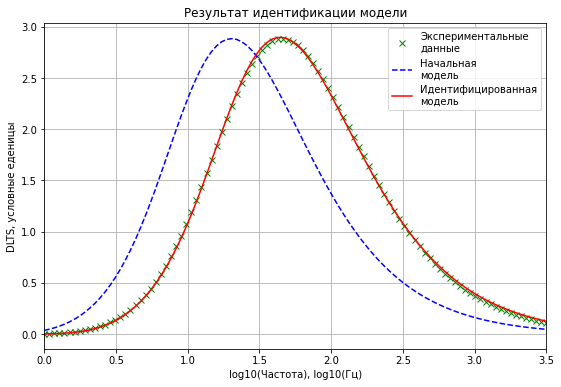

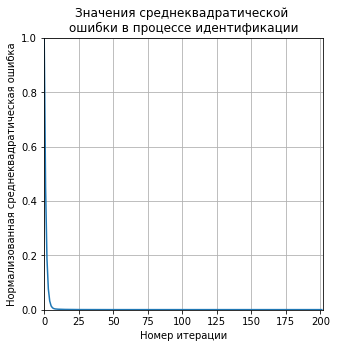

Спектр № 6
exps_params:
[[-2.2  1. ]
 [-2.   1. ]
 [-1.8  1. ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
6  2.854841           -1.999611  0.910967  0.000535


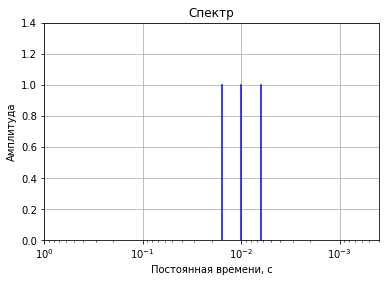

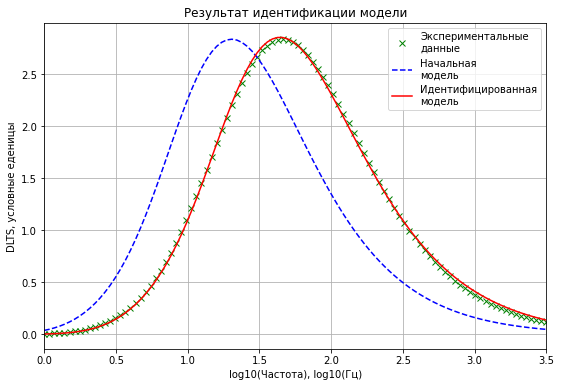

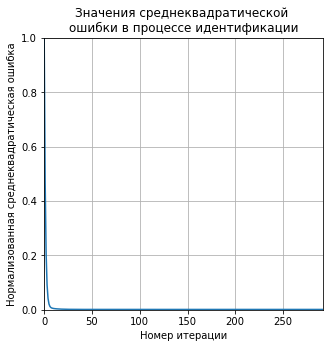

Спектр № 7
exps_params:
[[-2.23333333  1.        ]
 [-2.          1.        ]
 [-1.76666667  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
7  2.806237           -1.999227  0.881961  0.000943


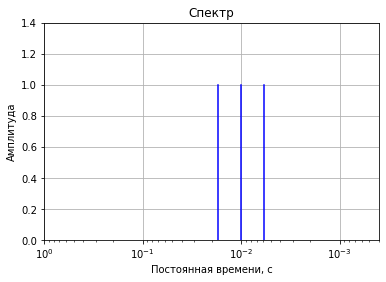

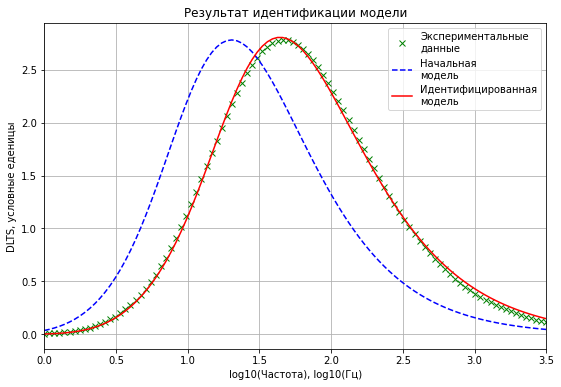

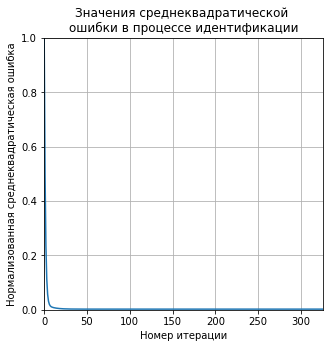

Спектр № 8
exps_params:
[[-2.26666667  1.        ]
 [-2.          1.        ]
 [-1.73333333  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
8  2.752448           -1.998633  0.850314  0.001521


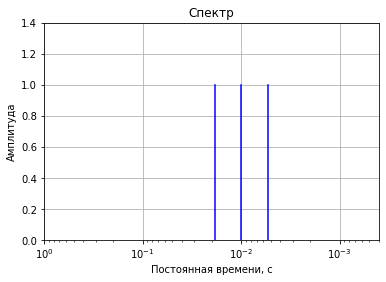

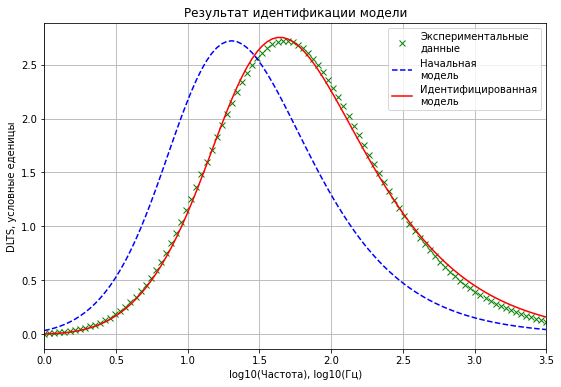

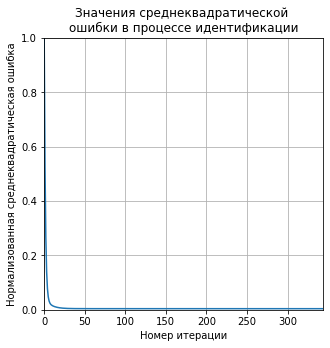

Спектр № 9
exps_params:
[[-2.3  1. ]
 [-2.   1. ]
 [-1.7  1. ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
9  2.694257           -1.997773  0.816602  0.002287


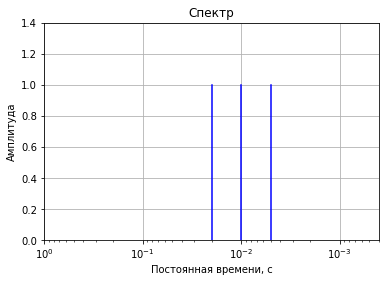

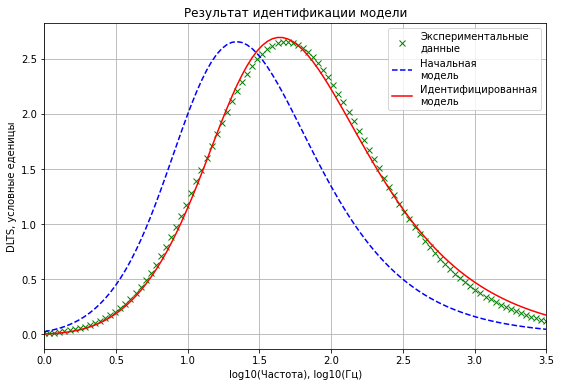

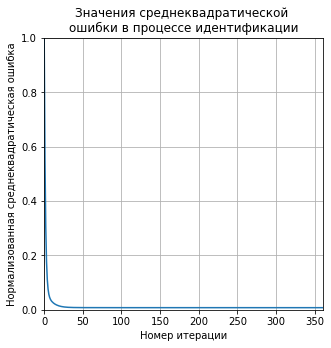

Спектр № 10
exps_params:
[[-2.33333333  1.        ]
 [-2.          1.        ]
 [-1.66666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power   p_coef      loss
10  2.632434           -1.996591  0.78137  0.003251


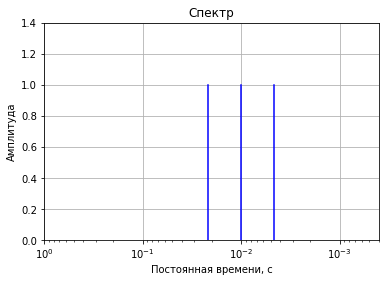

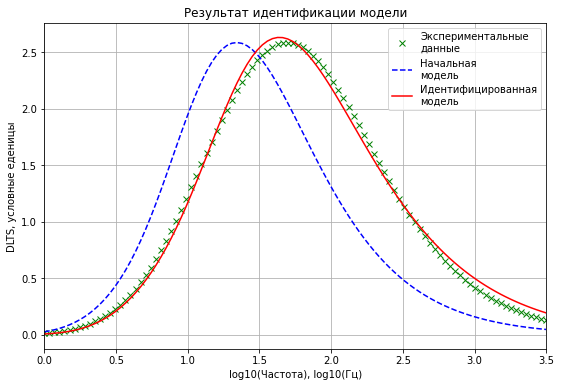

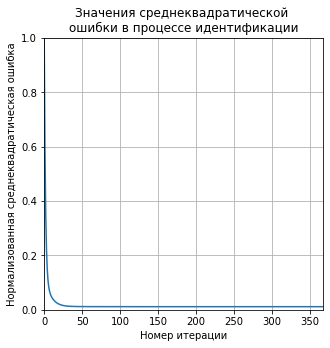

Спектр № 11
exps_params:
[[-2.36666667  1.        ]
 [-2.          1.        ]
 [-1.63333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
11  2.567737           -1.995028  0.745124  0.004408


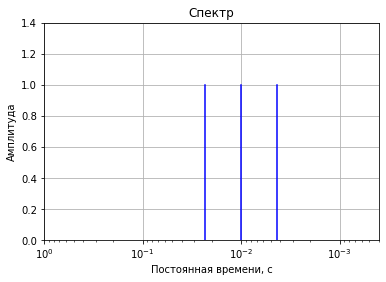

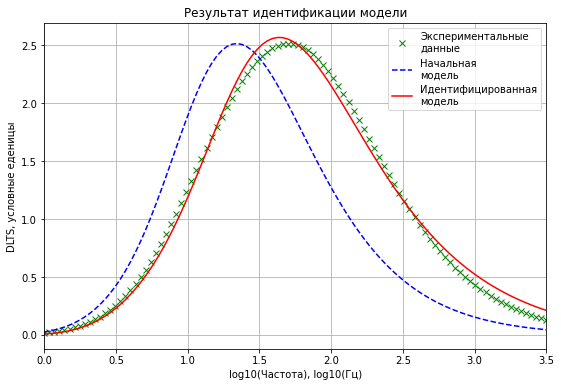

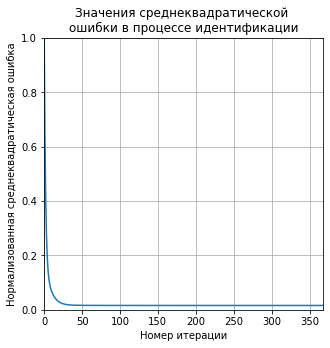

Спектр № 12
exps_params:
[[-2.4  1. ]
 [-2.   1. ]
 [-1.6  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
12  2.500874           -1.993033  0.708319  0.005745


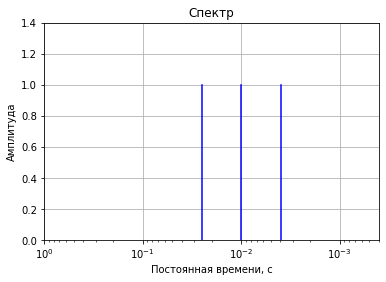

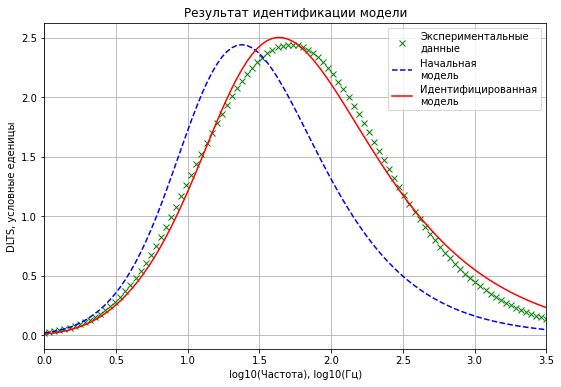

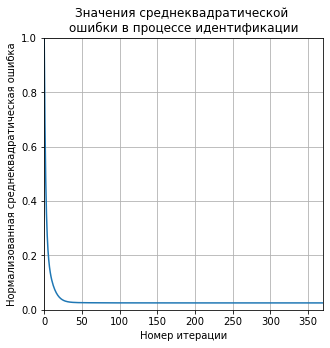

Спектр № 13
exps_params:
[[-2.43333333  1.        ]
 [-2.          1.        ]
 [-1.56666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
13   2.43251           -1.990556  0.671355  0.007235


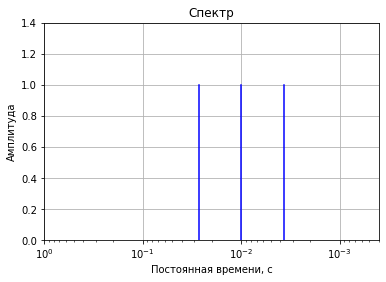

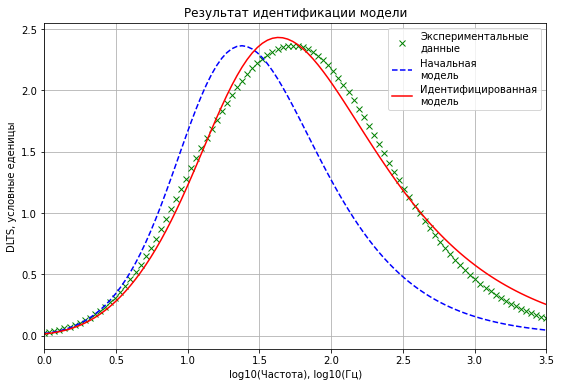

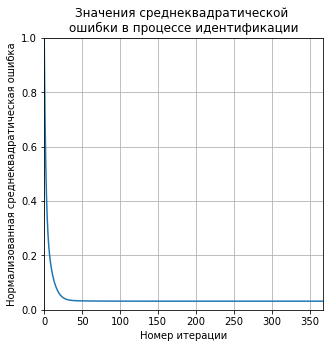

Спектр № 14
exps_params:
[[-2.46666667  1.        ]
 [-2.          1.        ]
 [-1.53333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
14   2.36325           -1.987557  0.634574  0.008842


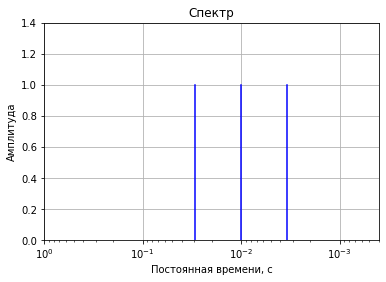

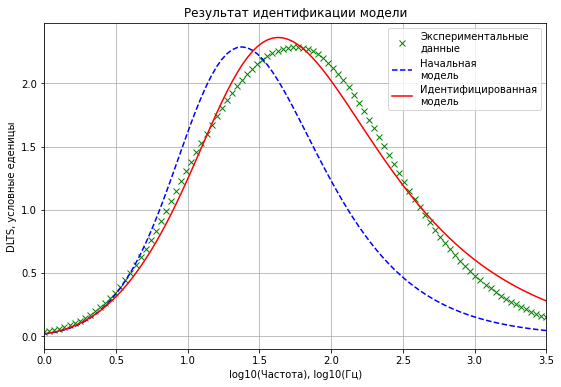

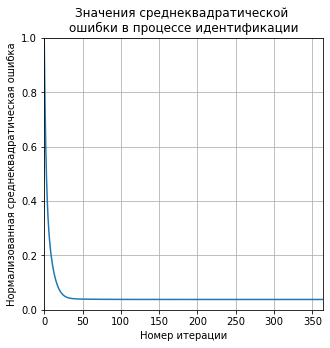

Спектр № 15
exps_params:
[[-2.5  1. ]
 [-2.   1. ]
 [-1.5  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
15  2.293634            -1.98401  0.598265  0.010522


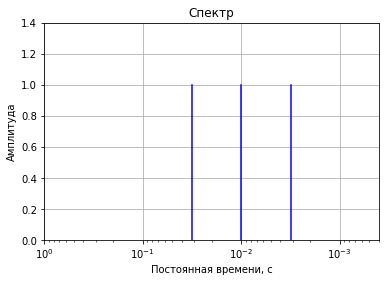

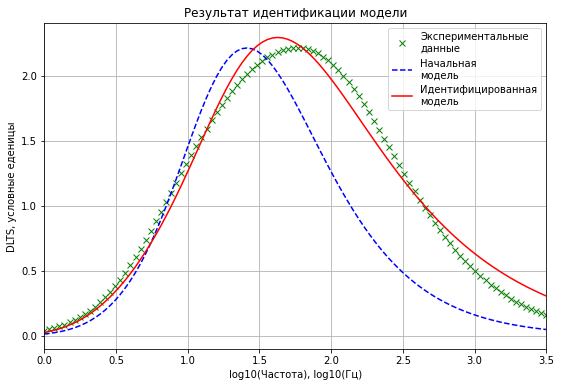

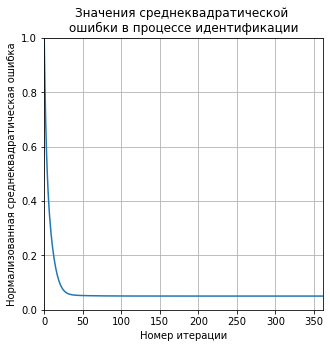

Спектр № 16
exps_params:
[[-2.53333333  1.        ]
 [-2.          1.        ]
 [-1.46666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
16  2.224148           -1.979899  0.562668  0.012227


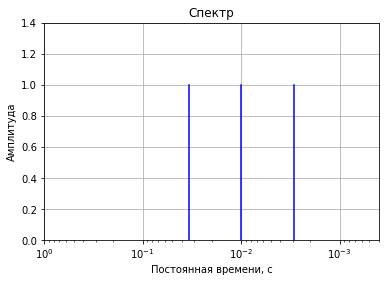

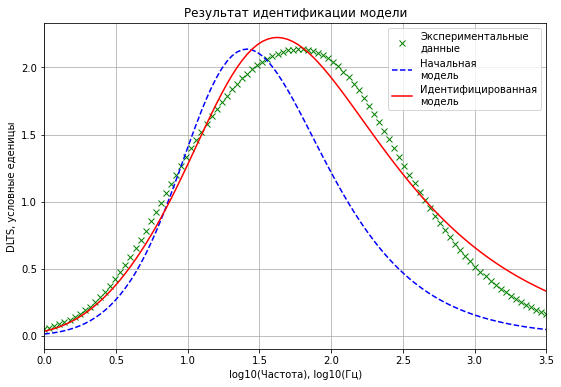

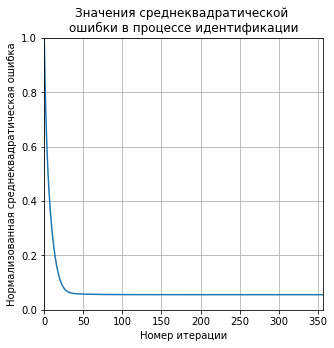

Спектр № 17
exps_params:
[[-2.56666667  1.        ]
 [-2.          1.        ]
 [-1.43333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
17  2.155211           -1.975229  0.527974  0.013904


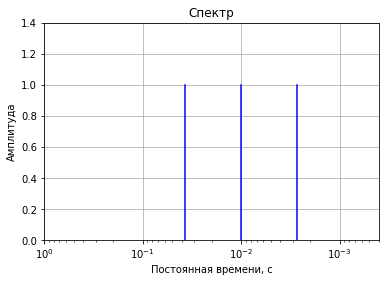

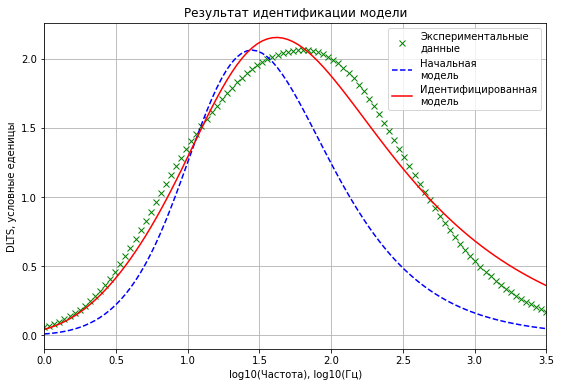

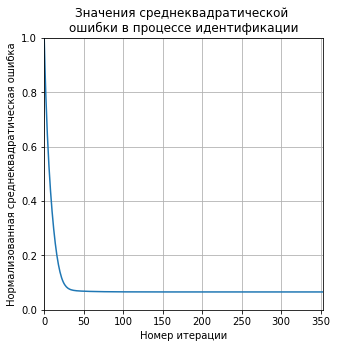

Спектр № 18
exps_params:
[[-2.6  1. ]
 [-2.   1. ]
 [-1.4  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
18  2.087183           -1.970021  0.494334  0.015505


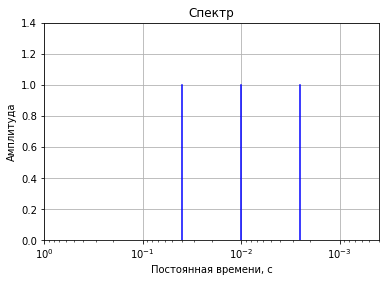

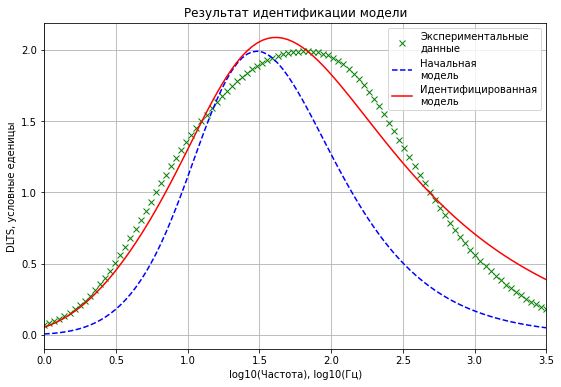

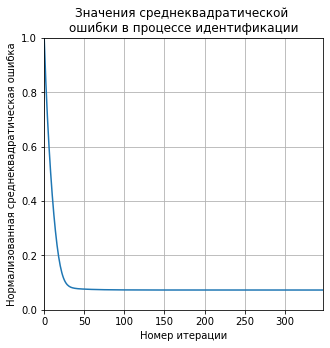

Спектр № 19
exps_params:
[[-2.63333333  1.        ]
 [-2.          1.        ]
 [-1.36666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
19  2.020364           -1.964314  0.461857  0.016982


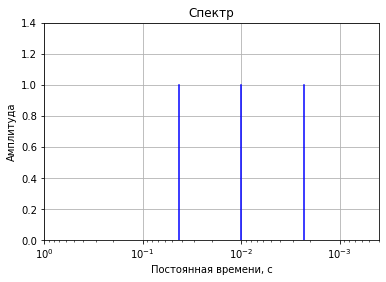

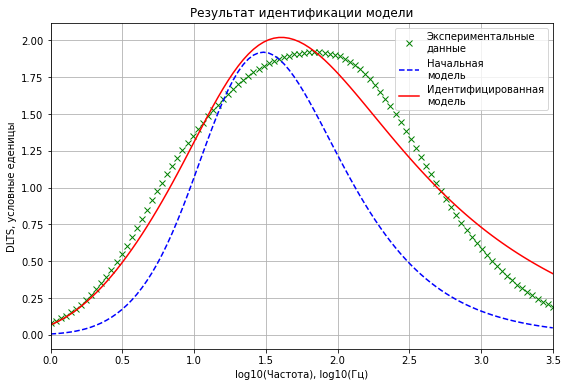

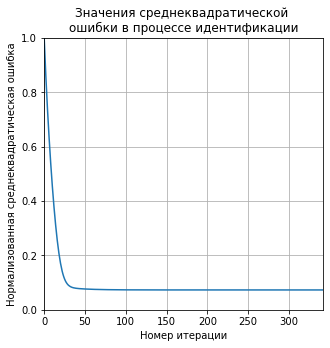

Спектр № 20
exps_params:
[[-2.66666667  1.        ]
 [-2.          1.        ]
 [-1.33333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
20  1.954992           -1.958164  0.430617  0.018296


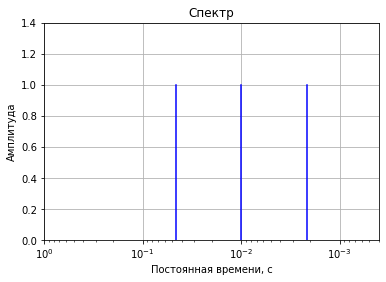

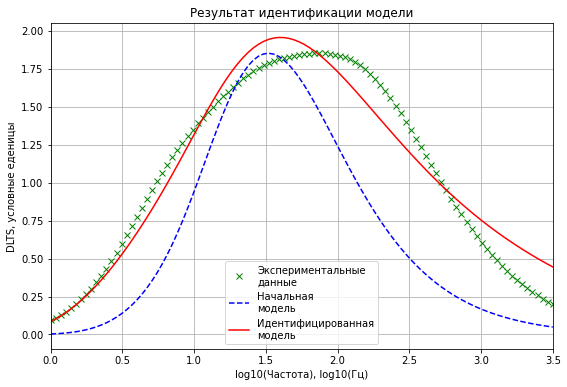

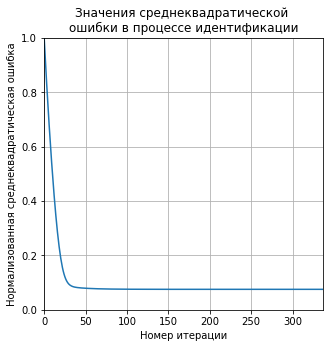

Спектр № 21
exps_params:
[[-2.7  1. ]
 [-2.   1. ]
 [-1.3  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
21  1.891252           -1.951643  0.400652  0.019415


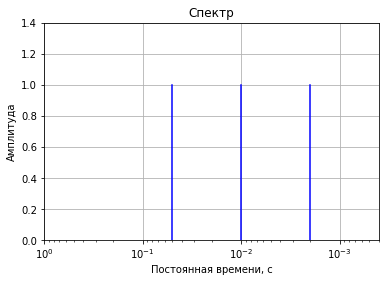

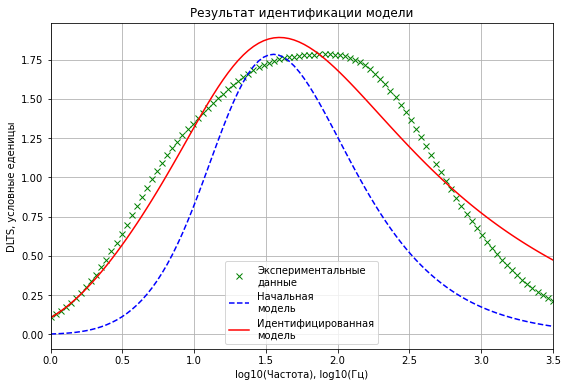

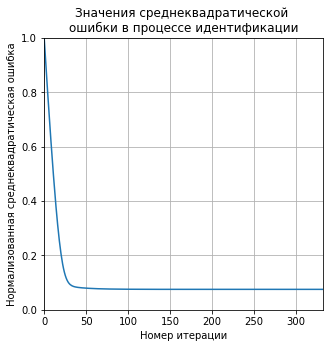

Спектр № 22
exps_params:
[[-2.73333333  1.        ]
 [-2.          1.        ]
 [-1.26666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power   p_coef      loss
22  1.829275           -1.944828  0.37197  0.020314


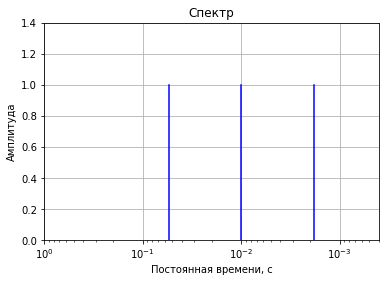

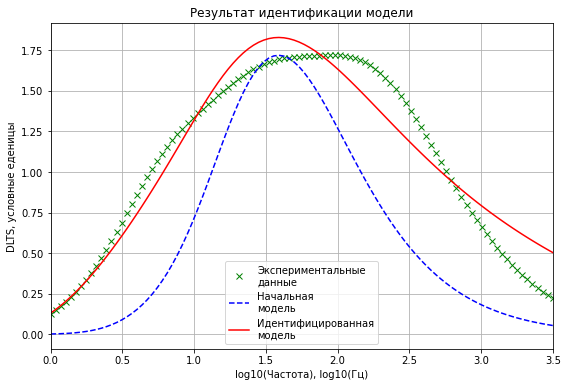

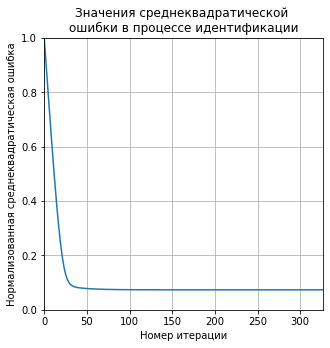

Спектр № 23
exps_params:
[[-2.76666667  1.        ]
 [-2.          1.        ]
 [-1.23333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
23  1.769138           -1.937803  0.344553  0.020979


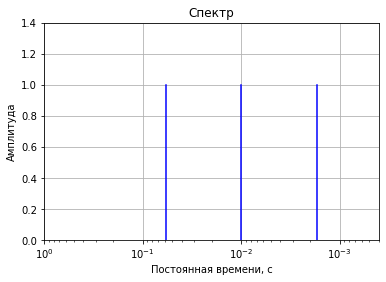

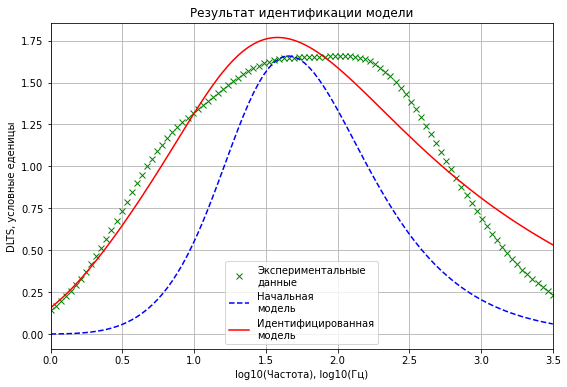

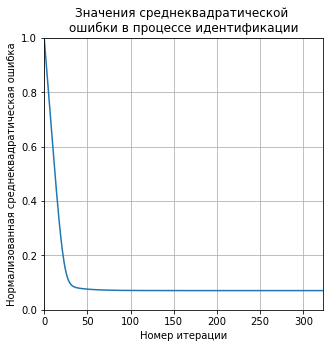

Спектр № 24
exps_params:
[[-2.8  1. ]
 [-2.   1. ]
 [-1.2  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
24  1.710877           -1.930654  0.318359  0.021404


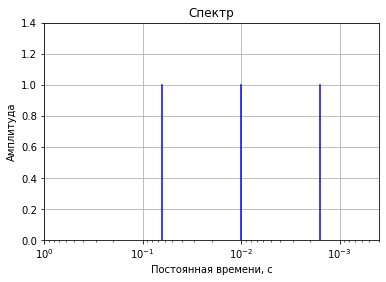

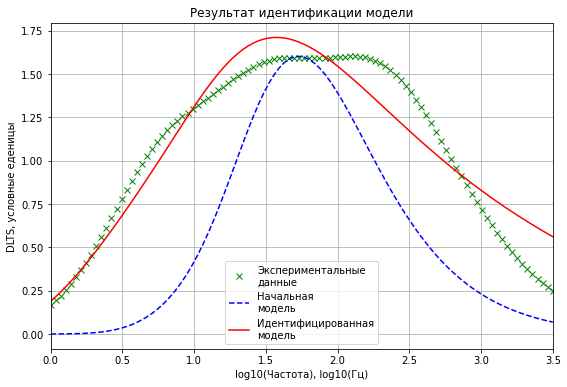

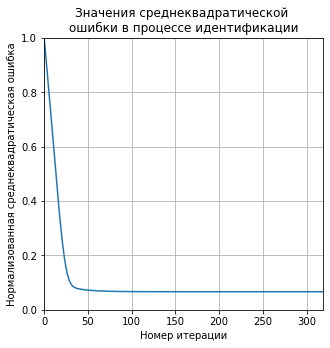

Спектр № 25
exps_params:
[[-2.83333333  1.        ]
 [-2.          1.        ]
 [-1.16666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
25  1.654492           -1.923463  0.293333  0.021592


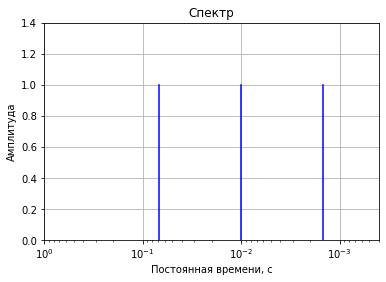

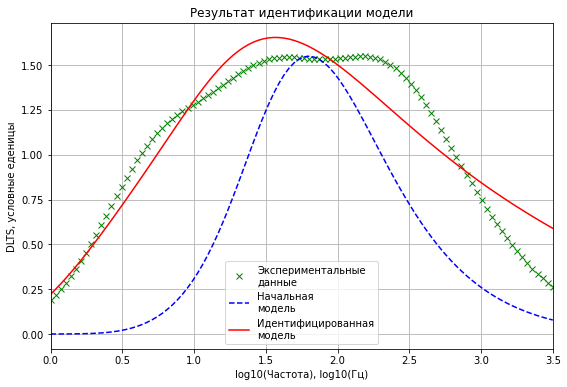

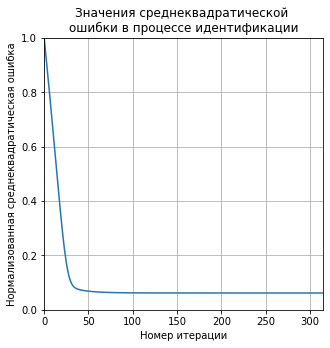

Спектр № 26
exps_params:
[[-2.86666667  1.        ]
 [-2.          1.        ]
 [-1.13333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
26   1.59995           -1.916309  0.269409  0.021553


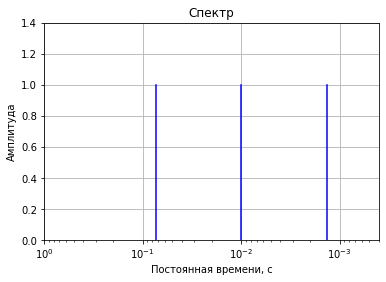

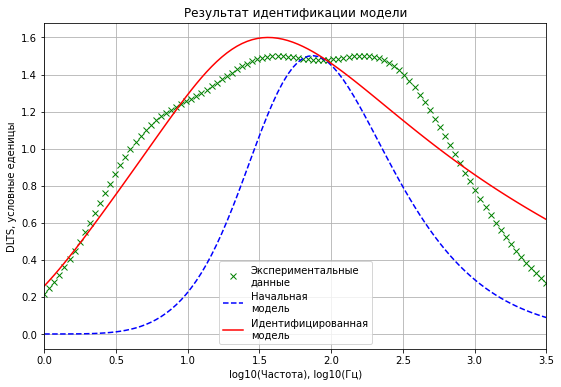

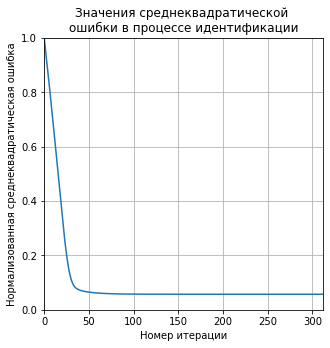

Спектр № 27
exps_params:
[[-2.9  1. ]
 [-2.   1. ]
 [-1.1  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
27  1.547201            -1.90927  0.246516  0.021303


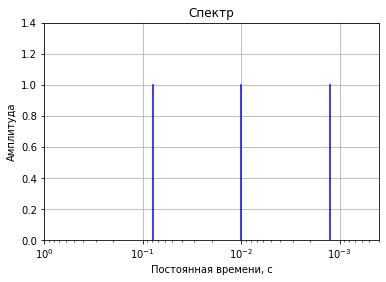

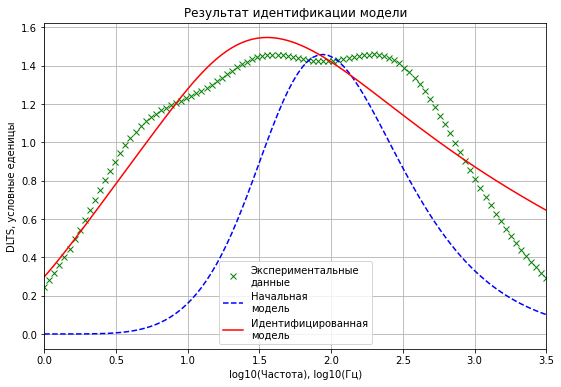

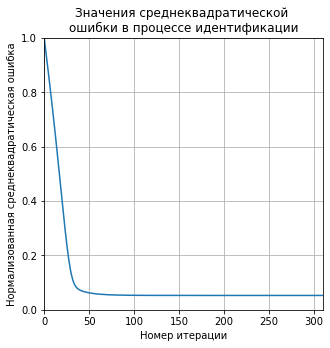

Спектр № 28
exps_params:
[[-2.93333333  1.        ]
 [-2.          1.        ]
 [-1.06666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
28  1.496184            -1.90242  0.224585  0.020866


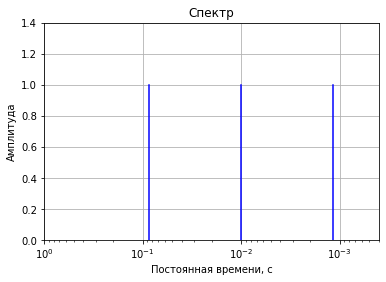

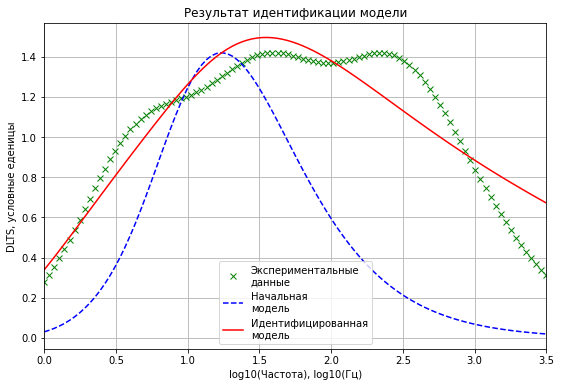

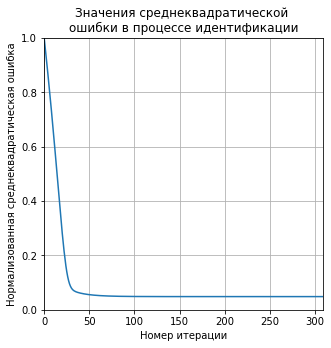

Спектр № 29
exps_params:
[[-2.96666667  1.        ]
 [-2.          1.        ]
 [-1.03333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
29   1.44682           -1.895847  0.203548  0.020268


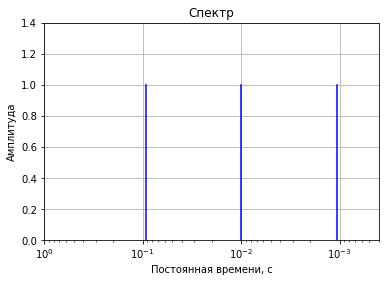

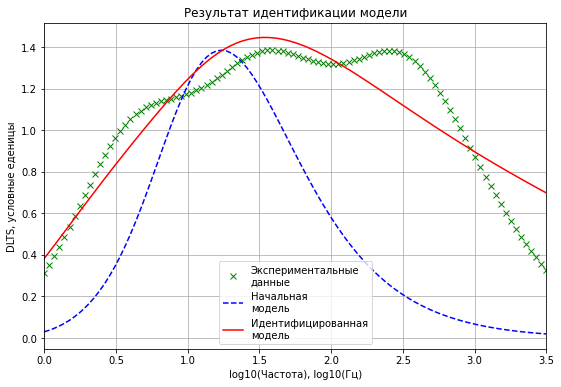

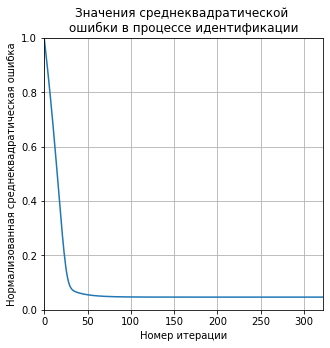

Спектр № 30
exps_params:
[[-3.  1.]
 [-2.  1.]
 [-1.  1.]]
Результаты идентификации:
   amplitude time_constant_power    p_coef     loss
30  1.399046           -1.889661  0.183347  0.01954


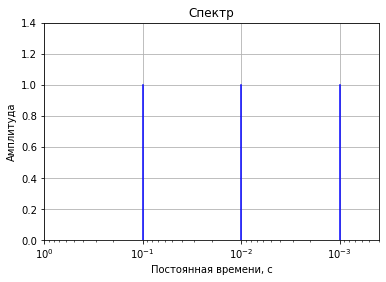

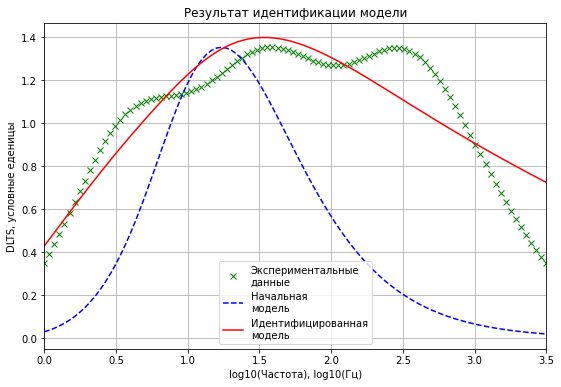

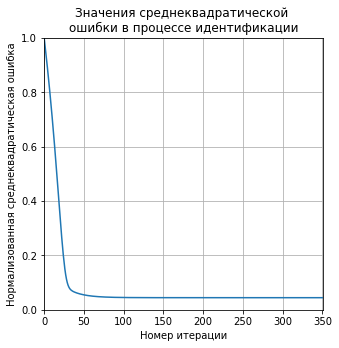

In [15]:
batch_plot(frequency_powers = FREQUENCY_POWERS, 
           experimental_values = test_data, 
           exps_params = exps_params,
           identification_results = identification_results,
           f_pulse = F_PULSE,
           save_to = '../plots/3-exp-clear/'
          )

## Зависимость $p$ от расстояния между линиями на спектре

In [16]:
def plot_p(exps_params, final_params, save_to=None):
    plt.figure(figsize=(10,7))

    max_dev = 10 ** exps_params[:, -1, 0] - 10 ** exps_params[:, 0, 0]
    plt.plot(max_dev, final_params.p_coef.to_numpy())
    plt.title('Зависимость коэффициента $p$ от расстояния между линиями на спектре')
    plt.xlabel(r'$\tau_0 - \tau_2$')
    plt.ylabel('Коэффициент $p$')
    plt.grid()

    if save_to is not None:
        plt.savefig(save_to + 'p_func.pdf', bbox_inches='tight')

    plt.show()

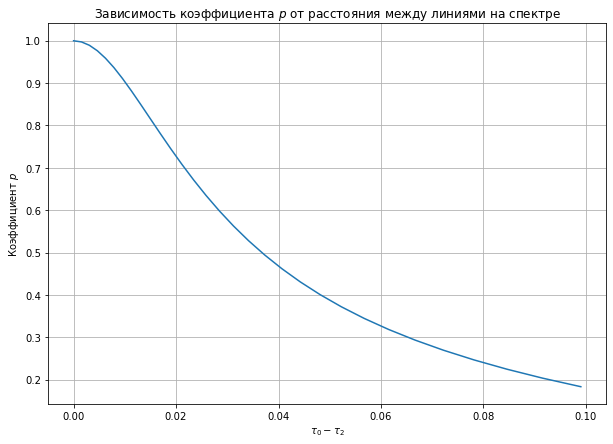

In [17]:
plot_p(exps_params=exps_params, 
       final_params=identification_results['final_params'], 
       save_to = '../plots/3-exp-clear/')